# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Alrbright, Gavin Fry

In [1]:
# Start with all of the includes we'll need for the project...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Begin...

In [4]:
df = pd.read_csv("reviews.csv")

In [5]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [6]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

In [8]:
# Clustering
df.head()

,steamid,appid,is_recommended,upvotes,votes_funny,helpful_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review
0,76561198795470246,599080,True,1,0,0.52381,400,400,230,2,Minus the quiet communication (other players s...
1,76561199026616351,599080,True,0,0,0.00000,745,192,19,8,yeah.
2,76561198259829110,599080,True,0,0,0.00000,1572,1572,50,4,Playing this game was the most fun I have ever...
3,76561198123742442,599080,True,0,0,0.00000,3684,2001,119,1,I love the interactive lore and story telling
4,76561198998908891,599080,True,0,0,0.00000,249,249,31,10,gg


In [26]:
# Sampling of the OG dataframe for use in the clustering
df2 = df[["votes_funny", "helpful_score"]]

# Drop 0's
df2= df2[df2['votes_funny'] != 0]
df2= df2[df2['helpful_score'] != 0]
data = df2.sample(n=5000, random_state = 1, replace = False)

# Filtering the dataframe to avoid outliers in the final product
q_lowFunny = data["votes_funny"].quantile(0.10)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Filtering cont'd
q_lowHelpful = data["helpful_score"].quantile(0.10)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Final filtering section and creation of filtered df
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

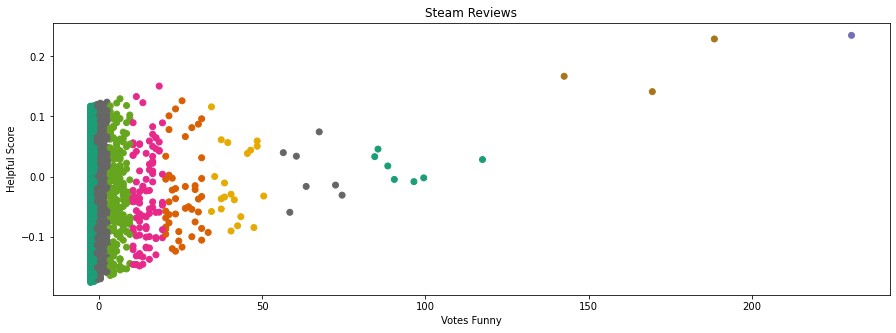

In [27]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()